# Assignment1 Sentiment Analysis

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from functools import reduce
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import html
import re
import nltk
from nltk.tokenize import RegexpTokenizer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from scipy import stats
import random
random.seed()

In [2]:
# load original data and stop words
generic_tweets = pd.read_csv('generic_tweets.txt')
airline_tweets = pd.read_csv('US_airline_tweets.csv')

with open('stop_words.txt','r') as f:
    stop_words = f.read().split('\n')

### Q1 Data Cleaning
Create a data cleaner to perform the data cleaning procedure in sequence:

- Encode according to ASCII
- Remove html tags and attributes
- Remove URLs
- Change to lower cases
- Remove stop words
- Remove all non-alphanumerical charactors

In [3]:
class DataCleaner(object):
    def __init__(self,stop_words=[""], remove_steps = []):
        super().__init__()
        self.hashtags = str()
        self.remove_steps = remove_steps
        self.stop_words = stop_words
        self.procedures = [getattr(self,procedure) for procedure in \
                        [step for step in sorted(dir(self)) if step.startswith("step_")]]
        # remove some procedures according to users' needs
        for i in sorted(self.remove_steps,reverse=True):
                self.procedures.pop(i-1)

    #use reduce to sequentially clean the raw data, equivelent to funcN(...func2(func1(data)))
    def clean(self, data):
            return reduce(lambda data,func:func(data),[data]+self.procedures),self.hashtags

    # Html character codes (i.e., &...;) are replaced with an ASCII equivalent.
    def step_01_to_ascii(self,data):
        return html.unescape(data)

    # Remove html tags and attributes in form of <...>
    def step_02_remove_html_tag(self,data):
        return re.sub(r"\s*<.*?>",'', data)

    # Remove url in form of (http or https://)address.domain(/file)
    def step_03_remove_url(self,data):
        return re.sub(r'\s*(?:https?:\/\/)?[\w.-]+(?:\.[\w.-]+)+[\w\-._~:/?#[\]@!\$&\'\(\)\*\+,;=.]+','',data)

    # Change all characters in the text to lowercase.
    def step_04_to_lower(self,data):
        return data.lower()

    # Retrive @ tag message
    def step_05_hash_tag_retrieval(self,data):
        self.hashtags = ' '.join(re.findall(r'(?<=@)[^\s]+\s?',data))
        return re.sub(r'@.*?\s','',data)

    # Remove punctuation
    def step_06_remove_punctuation(self,data):
        tokenizer = RegexpTokenizer(r'\w+')
        words_list = tokenizer.tokenize(data)
        return ' '.join(words_list)

    # Remove stop words
    def step_07_remove_stop_words(self,data):
        words = data.split()
        new_data = [word for word in words if word not in self.stop_words]
        return ' '.join(new_data) #clean up empty charactor

    # Remove non alphanumeric characters except space
    def step_08_remove_nonAlphaNumerical(self,data):
        return re.sub(r'[^\s\w]+','',data)

In [4]:
myCleaner = DataCleaner(stop_words)
airline_tweets['clean_text'],airline_tweets['@_tags'] = np.vectorize(myCleaner.clean)(airline_tweets['text'])

In [5]:
def LabelKey(data,text):
    airlines = ['americanair','usairways','bostonlogan','united',\
               'deltaassist','jetblue','southwestair','virginamerica']
    for airline in airlines:
        if data.find(airline)>=0:
            return airline
    for airline in airlines:
        if text.lower().find(airline)>=0:
            return airline
    return "Unknown"

In [6]:
airline_tweets['airline'] = [LabelKey(a,b) for a, b in zip(airline_tweets['@_tags'],airline_tweets['text'])]

In [7]:
# LabelKey(airline_tweets.iloc[6184]['@_tags'],airline_tweets.iloc[6184]['text'])

Text(0.5,1,'Distribution of the Political Affliation of the Tweets')

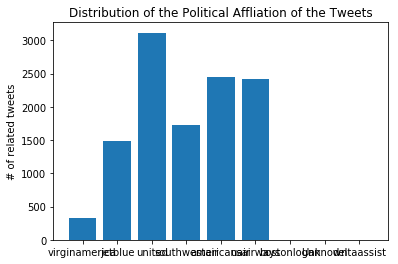

In [8]:
# plot a histogram
x = Counter(airline_tweets['airline'])
l = range(len(x.keys()))
plt.bar(l, x.values(), align='center')
plt.xticks(l, x.keys())
plt.ylabel('# of related tweets')
plt.title('Distribution of the Political Affliation of the Tweets')